In [ ]:
!pip install torch 
!pip install numpy 

In [1]:
import os
import sys
import math
import torch
import numpy as np
from torch import nn
import torch.nn as nn
sys.path.append("..")
from torch.nn import Parameter
import torch.nn.functional as F
from __future__ import print_function
from torch.optim import Adam, lr_scheduler
from torchvision.ops import stochastic_depth
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']


ModuleNotFoundError: No module named 'torch'

# Load Dataset

**def extract_classes():**
The function initializes a boolean mask (idx) with False values. It then iterates over the given class labels and updates the mask to True where the dataset's target matches the class. Finally, it uses this mask to extract the relevant data and targets.

**def getDataset():**
This function defines transformations such as resizing, random horizontal flipping, and conversion to a tensor. It then loads the CIFAR-10 dataset using torchvision, downloading it if necessary. CIFAR-10 has 10 classes and RGB images, which means the number of input channels is 3.

**def getDataloader():** This function first determines the total number of training samples and shuffles the indices. It then splits the indices into training and validation sets based on valid_size. Using SubsetRandomSampler, it creates samplers for the training and validation datasets.

In [ ]:
def extract_classes(dataset, classes):
    """
    Extracts data samples from a dataset that belong to specific classes.

    Parameters:
    - dataset (torchvision dataset): A dataset object that contains `data` (features) and `targets` (labels).
    - classes (list of int): A list of class labels to filter from the dataset.

    Returns:
    - data (torch.Tensor): A tensor containing only the samples that match the specified classes.
    - targets (torch.Tensor): A tensor containing the corresponding labels for the filtered samples.
    """
    idx = torch.zeros_like(dataset.targets, dtype=torch.bool)
    for target in classes:
        idx = idx | (dataset.targets==target)

    data, targets = dataset.data[idx], dataset.targets[idx]
    return data, targets


def getDataset(dataset):
    """
    Loads the CIFAR10 dataset and applies necessary transformations.

    Parameters:
    - dataset (str): A string specifying the dataset name.

    Returns:
    - trainset: The training dataset with applied transformations.
    - testset: The testing dataset with applied transformations.
    - inputs (int): The number of input channels.
    - num_classes (int): The number of classes in the dataset. For the CIFAR-10 dataset 10 classes.
    """
    transform_cifar = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        ])

    if(dataset == 'CIFAR10'):
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
        num_classes = 10
        inputs=3  #Input Channel as this is RGB Image

    return trainset, testset, inputs, num_classes


def getDataloader(trainset, testset, valid_size, batch_size, num_workers):
    """
    Creates data loaders for training, validation, and testing.

    Parameters:
    - trainset: The training dataset.
    - testset: The testing dataset.
    - valid_size (float): The proportion of training data to use for validation.
    - batch_size (int): The batch size for the data loaders.
    - num_workers (int): The number of worker threads for data loading.

    Returns:
    - train_loader: DataLoader for the training set.
    - valid_loader: DataLoader for the validation set.
    - test_loader: DataLoader for the test set.
    """
    num_train = len(trainset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
        sampler=train_sampler, num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
        sampler=valid_sampler, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
        num_workers=num_workers)

    return train_loader, valid_loader, test_loader

# Utils Functions

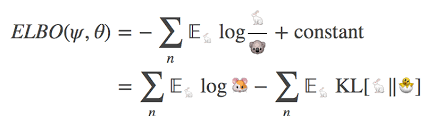

*   Implements the **Evidence Lower Bound (ELBO)** loss, which balances likelihood loss and KL divergence.
*   The forward() method computes **ELBO loss** = **neg_loglikelihood_loss** + **beta** * **kl**.



In [ ]:
class ELBO(nn.Module):
    """
    Evidence Lower Bound (ELBO) loss module for Variational Inference.

    Parameters:
    - train_size (int): The total number of training samples.

    Methods:
    - forward(input, target, kl, beta): Computes the ELBO loss.
    """
    def __init__(self, train_size):
        super().__init__()
        self.train_size = train_size

    def forward(self, input, target, kl, beta):
        assert not target.requires_grad

        neg_loglikehood_loss = F.nll_loss(input, target, reduction='mean') * self.train_size
        elbo_loss = neg_loglikehood_loss + beta * kl
        return elbo_loss

In [ ]:
def adjust_learning_rate(optimizer, lr):
    """
    Adjusts the learning rate for an optimizer.

    Parameters:
    - optimizer (torch.optim.Optimizer): The optimizer to update.
    - lr (float): The new learning rate.
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def acc(outputs, targets):
    """
    Computes the accuracy of the model's predictions.

    Parameters:
    - outputs (torch.Tensor): The model's output logits.
    - targets (torch.Tensor): The true class labels.

    Returns:
    - accuracy (float): The computed accuracy score.
    """
    return np.mean(outputs.cpu().numpy().argmax(axis=1) == targets.data.cpu().numpy())

def save_array_to_file(numpy_array, filename):
    """
    Saves a NumPy array to a file in a space-separated format.

    Parameters:
    - numpy_array (numpy.ndarray): The array to save.
    - filename (str): The name of the output file.
    """
    file = open(filename, 'a')
    shape = " ".join(map(str, numpy_array.shape))
    np.savetxt(file, numpy_array.flatten(), newline=" ", fmt="%.3f")
    file.write("\n")
    file.close()

**KL Divergence Formula**

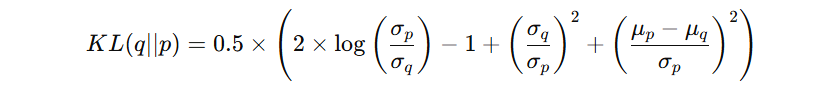

In [ ]:
import os
import torch
import numpy as np
from torch.nn import functional as F

def logmeanexp(x, dim=None, keepdim=False):
    """
    Computes the log-mean-exp of a tensor along a specified dimension.

    This function is useful for numerical stability when dealing with logarithmic
    calculations in probabilistic models.

    Parameters:
    - x (torch.Tensor): Input tensor.
    - dim (int, optional): Dimension along which to compute log-mean-exp. Defaults to None,
      meaning it flattens the tensor before computing.
    - keepdim (bool, optional): Whether to retain the reduced dimension in the output.

    Returns:
    - torch.Tensor: The log-mean-exp of the input tensor.
    """
    if dim is None:
        x, dim = x.view(-1), 0
    x_max, _ = torch.max(x, dim, keepdim=True)
    x = x_max + torch.log(torch.mean(torch.exp(x - x_max), dim, keepdim=True))
    return x if keepdim else x.squeeze(dim)

def calculate_kl(mu_q, sig_q, mu_p, sig_p):
    """
    Computes the Kullback-Leibler (KL) divergence between two Gaussian distributions.

    The KL divergence measures how much one probability distribution differs from another.
    In this case, we compute the KL divergence between a variational posterior `q` and a prior `p`.

    Parameters:
    - mu_q (torch.Tensor): Mean of the approximate posterior (q).
    - sig_q (torch.Tensor): Standard deviation of the approximate posterior (q).
    - mu_p (torch.Tensor): Mean of the prior distribution (p).
    - sig_p (torch.Tensor): Standard deviation of the prior distribution (p).

    Returns:
    - kl (torch.Tensor): The KL divergence value.
    """
    kl = 0.5 * (2 * torch.log(sig_p / sig_q) - 1 + (sig_q / sig_p).pow(2) + ((mu_p - mu_q) / sig_p).pow(2)).sum()
    return kl

In [ ]:
class ModuleWrapper(nn.Module):
    """Wrapper for nn.Module with support for arbitrary flags and a universal forward pass"""

    def __init__(self):
        super().__init__()

    def set_flag(self, flag_name, value):
        setattr(self, flag_name, value)
        for m in self.children():
            if hasattr(m, 'set_flag'):
                m.set_flag(flag_name, value)

    def forward(self, x):
        for module in self.children():
            x = module(x)
        kl = 0.0
        for module in self.modules():
            if hasattr(module, 'kl_loss'):
                kl = kl + module.kl_loss()
        return x, kl

class FlattenLayer(ModuleWrapper):
    def __init__(self, num_features):
        super(FlattenLayer, self).__init__()
        self.num_features = num_features

    def forward(self, x):
        return x.view(-1, self.num_features)

# Bayesian Convolutional Operation:

The BBBConv2d class implements a Bayesian Convolutional Layer using the Bayes-by-Backprop (BBB) approach. This layer is designed to model uncertainty in the weights of a CNN by treating them as probability distributions rather than fixed values. It learns distributions over weights, enabling uncertainty estimation.

In Bayesian neural networks, each weight is modeled as a Gaussian distribution. Instead of learning a single weight value, we learn:
*   Mean (μ): The expected value of the weight.
*   Standard deviation (σ): A measure of uncertainty.

In [ ]:
class BBBConv2d(ModuleWrapper):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, bias=True, priors=None, groups=1):
        super(BBBConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.use_bias = bias
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        if priors is None:
            priors = {
                'prior_mu': 0,
                'prior_sigma': 0.1,
                'posterior_mu_initial': (0, 0.1),
                'posterior_rho_initial': (-3, 0.1),
            }
        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        self.W_mu = Parameter(torch.empty((out_channels, in_channels // groups, *self.kernel_size), device=self.device))
        self.W_rho = Parameter(torch.empty((out_channels, in_channels // groups, *self.kernel_size), device=self.device))

        if self.use_bias:
            self.bias_mu = Parameter(torch.empty((out_channels), device=self.device))
            self.bias_rho = Parameter(torch.empty((out_channels), device=self.device))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_rho', None)

        self.reset_parameters()

    def reset_parameters(self):
        """Description:
          Initializes the weight (W_mu, W_rho) and bias (bias_mu, bias_rho) parameters using normal distributions with specified mean and
          standard deviation values, as defined in the posterior_mu_initial and posterior_rho_initial attributes.

          Parameters:
          None

          Returns:
          None (Resets the parameters in place).
        """
        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)

        if self.use_bias:
            self.bias_mu.data.normal_(*self.posterior_mu_initial)
            self.bias_rho.data.normal_(*self.posterior_rho_initial)

    def forward(self, input, sample=True):
        """Description:
        This function generates random noise from a normal distribution and computes the Bayesian weights and biases using learned parameters. It adds variability to the weights and biases by combining their mean with scaled noise, allowing for randomness in the model. If no bias is used, the bias is set to None. After calculating the Bayesian weights and biases, it performs a traditional 2D convolution operation (F.conv2d()), returning the output.

        Parameters:
        input (Tensor): The input tensor to the convolutional layer.
        sample (bool, optional): If set to True, the function samples the weights and biases using the learned distributions. If False, the mean weights and biases (W_mu, bias_mu) are used directly. Default is True.

        Returns:
        Tensor: The result of the convolution operation, which is the input processed by the sampled (or mean) weights and biases."""
        W_eps = torch.empty(self.W_mu.size()).normal_(0, 1).to(self.device)
        self.W_sigma = torch.log1p(torch.exp(self.W_rho))
        weight = self.W_mu + W_eps * self.W_sigma

        if self.use_bias:
            bias_eps = torch.empty(self.bias_mu.size()).normal_(0, 1).to(self.device)
            self.bias_sigma = torch.log1p(torch.exp(self.bias_rho))
            bias = self.bias_mu + bias_eps * self.bias_sigma
        else:
            bias = None

        # Forward pass with grouped convolution
        return F.conv2d(input, weight, bias, self.stride, self.padding, self.dilation, self.groups)

    def kl_loss(self):
        kl = calculate_kl(self.prior_mu, self.prior_sigma, self.W_mu, self.W_sigma)
        if self.use_bias:
            kl += calculate_kl(self.prior_mu, self.prior_sigma, self.bias_mu, self.bias_sigma)
        return kl

# Bayesian Linear Layer

In [ ]:
class BBBLinear(ModuleWrapper):
    def __init__(self, in_features, out_features, bias=True, priors=None):
        super(BBBLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = bias
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        if priors is None:
            priors = {
                'prior_mu': 0,
                'prior_sigma': 0.1,
                'posterior_mu_initial': (0, 0.1),
                'posterior_rho_initial': (-3, 0.1),
            }
        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        self.W_mu = Parameter(torch.empty((out_features, in_features), device=self.device))
        self.W_rho = Parameter(torch.empty((out_features, in_features), device=self.device))

        if self.use_bias:
            self.bias_mu = Parameter(torch.empty((out_features), device=self.device))
            self.bias_rho = Parameter(torch.empty((out_features), device=self.device))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_rho', None)

        self.reset_parameters()

    def reset_parameters(self):
        """Description:
            Resets the weight and bias parameters (W_mu, W_rho, bias_mu, bias_rho) to random values drawn from normal distributions defined by the initial posterior values.

            Parameters:
            None

            Returns:
            None (Resets the parameters in place).
        """
        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)

        if self.use_bias:
            self.bias_mu.data.normal_(*self.posterior_mu_initial)
            self.bias_rho.data.normal_(*self.posterior_rho_initial)

    def forward(self, input, sample=True):
        """Description:
              Computes the output of the Bayesian linear layer by adding variability to the weights and bias using learned distributions.
              The function generates random noise, scales it by the learned standard deviation, and combines it with the mean to produce the final weight and bias.
              The resulting weights and biases are then used in a linear transformation of the input.

              Parameters:
              input (Tensor): The input tensor to the linear layer.
              sample (bool, optional): If True, the function samples the weights and bias using the learned distributions. If False, the function uses the mean weights and bias directly. Default is True.

              Returns:
              Tensor: The output of the linear transformation using the sampled (or mean) weights and bias.
        """
        W_eps = torch.empty(self.W_mu.size()).normal_(0, 1).to(self.device)
        self.W_sigma = torch.log1p(torch.exp(self.W_rho))
        weight = self.W_mu + W_eps * self.W_sigma

        if self.use_bias:
            bias_eps = torch.empty(self.bias_mu.size()).normal_(0, 1).to(self.device)
            self.bias_sigma = torch.log1p(torch.exp(self.bias_rho))
            bias = self.bias_mu + bias_eps * self.bias_sigma
        else:
            bias = None
        return F.linear(input, weight, bias)

    def kl_loss(self):
        kl = calculate_kl(self.prior_mu, self.prior_sigma, self.W_mu, self.W_sigma)
        if self.use_bias:
            kl += calculate_kl(self.prior_mu, self.prior_sigma, self.bias_mu, self.bias_sigma)
        return kl

# Bayesian Variants of Popular Architectures

I have developed **BBBAlexNet, BBBLeNet, BBBResNet-50, and BBBConvNeXT** — Bayesian variants of the AlexNet, LeNet, ResNet-50, and ConvNeXT architectures, respectively. These models incorporate **BBBConv2d** for the convolutional layers and **BBBLinear** for the fully connected layers, enabling uncertainty estimation within the network. While the overall architecture remains the same as the traditional architectures, these Bayesian layers introduce a probabilistic approach by incorporating uncertainty into the weights. For non-linearity, both **SoftPlus** and **ReLU** activation functions have been utilized.

# AlexNet Architecture


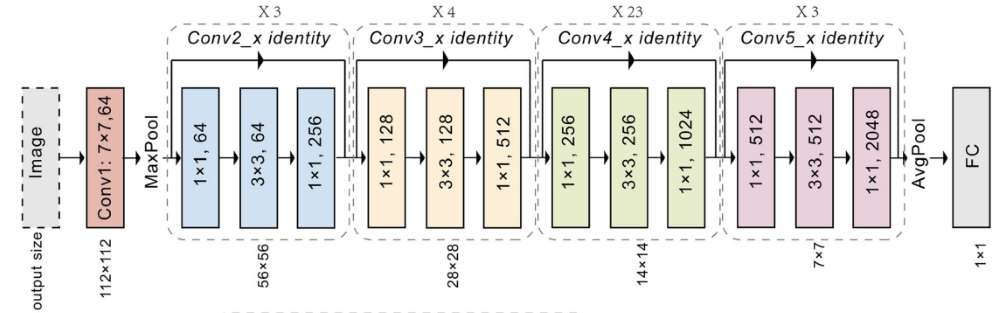

In [ ]:
class BBBAlexNet(ModuleWrapper):
    '''The architecture of AlexNet with Bayesian Layers'''

    def __init__(self, outputs, inputs, priors, layer_type='lrt', activation_type='softplus'):
        super(BBBAlexNet, self).__init__()

        self.num_classes = outputs
        self.layer_type = layer_type
        self.priors = priors

        if activation_type=='softplus':
            self.act = nn.Softplus
        elif activation_type=='relu':
            self.act = nn.ReLU
        else:
            raise ValueError("Only softplus or relu supported")

        self.conv1 = BBBConv2d(inputs, 64, 11, stride=4, padding=5, bias=True, priors=self.priors)
        self.act1 = self.act()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = BBBConv2d(64, 192, 5, padding=2, bias=True, priors=self.priors)
        self.act2 = self.act()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = BBBConv2d(192, 384, 3, padding=1, bias=True, priors=self.priors)
        self.act3 = self.act()

        self.conv4 = BBBConv2d(384, 256, 3, padding=1, bias=True, priors=self.priors)
        self.act4 = self.act()

        self.conv5 = BBBConv2d(256, 128, 3, padding=1, bias=True, priors=self.priors)
        self.act5 = self.act()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = FlattenLayer(1 * 1 * 128)
        self.classifier = BBBLinear(1 * 1 * 128, outputs, bias=True, priors=self.priors)

# Bayesian LeNet Architecture

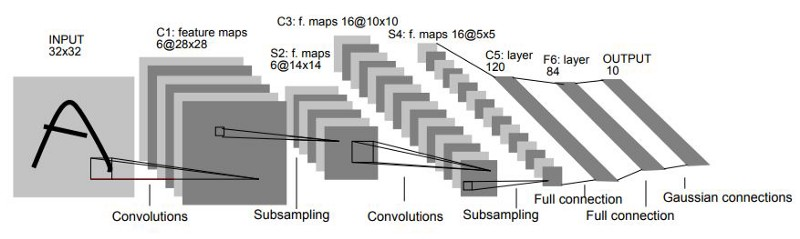

In [ ]:
class BBBLeNet(ModuleWrapper):
    def __init__(self, outputs, inputs, priors, layer_type, activation_type='softplus'):
        """Description:
            Initializes the BBBLeNet model with Bayesian convolutional and linear layers. This constructor sets up the network layers, activation functions, and prior distributions for Bayesian inference.

            Parameters:

            outputs (int): The number of output classes (for classification).
            inputs (int): The number of input channels (e.g., 1 for grayscale or 3 for RGB images).
            priors (dict): A dictionary containing prior distribution parameters for the Bayesian layers.
            layer_type (str): Specifies the type of layers to use. This might define the type of initialization or regularization used in the layers.
            activation_type (str, optional): The activation function to use. It can be either 'softplus' or 'relu'. Default is 'softplus'.
            Returns:

            None (Initializes the model architecture, activation functions, and layers).
        """
        super(BBBLeNet, self).__init__()

        self.num_classes = outputs
        self.layer_type = layer_type
        self.priors = priors

        if activation_type == 'softplus':
            self.act = nn.Softplus
        elif activation_type == 'relu':
            self.act = nn.ReLU
        else:
            raise ValueError("Only softplus or relu supported")

        self.conv1 = BBBConv2d(inputs, 6, 5, padding=0, bias=True, priors=self.priors)
        self.act1 = self.act()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = BBBConv2d(6, 16, 5, padding=0, bias=True, priors=self.priors)
        self.act2 = self.act()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = FlattenLayer(5 * 5 * 16)
        self.fc1 = BBBLinear(5 * 5 * 16, 120, bias=True, priors=self.priors)
        self.act3 = self.act()

        self.fc2 = BBBLinear(120, 84, bias=True, priors=self.priors)
        self.act4 = self.act()

        self.fc3 = BBBLinear(84, outputs, bias=True, priors=self.priors)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.act3(x)

        x = self.fc2(x)
        x = self.act4(x)

        x = self.fc3(x)

        kl_div = 0.0
        for module in self.modules():
            if hasattr(module, 'kl_loss'):
                kl_div += module.kl_loss()

        return x, kl_div

# ResNet-50 Architecture

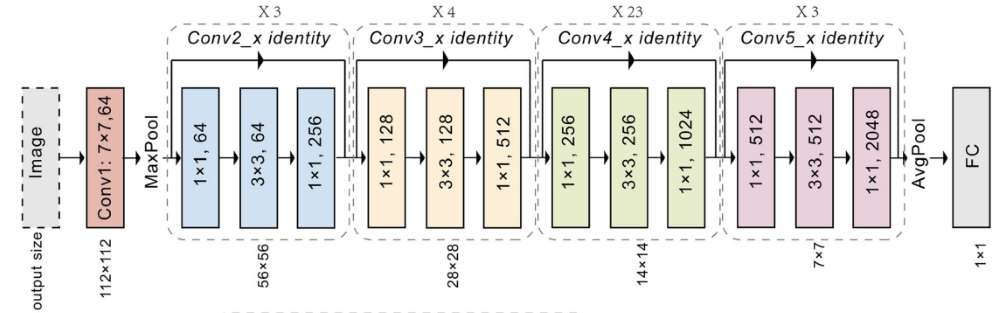

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class Bottleneck(ModuleWrapper):
    """
    The Bottleneck class defines a bottleneck block used in ResNet architectures.
    It applies three convolutional layers with Bayesian convolutional layers,
    batch normalization, and a residual connection.

    Args:
        in_channels (int): Number of input channels for the bottleneck block.
        out_channels (int): Number of output channels (before expansion).
        i_downsample (nn.Module, optional): A downsampling layer for matching dimensions in case of a mismatch between input and output channels.
        stride (int, optional): The stride of the second convolutional layer. Default is 1.
        priors (dict, optional): The prior distribution for Bayesian layers. Default is None.
    """
    expansion = 4

    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1, priors=None):
        super(Bottleneck, self).__init__()
        self.priors = priors

        self.conv1 = BBBConv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, priors=self.priors)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = BBBConv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, priors=self.priors)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = BBBConv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, priors=self.priors)
        self.batch_norm3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.i_downsample = i_downsample
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Forward pass for the bottleneck block. It has three bayesian convolutional layers. First it creates the identity of the input and
        then pass to through three consecutive bayesian conv block followed by some relu activation layer. Finally it has been added with the original input
        with the output to produce final result.
        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Output tensor after the forward pass with residual connection applied.
        """
        identity = x.clone()

        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.relu(self.batch_norm2(self.conv2(x)))
        x = self.conv3(x)
        x = self.batch_norm3(x)

        if self.i_downsample is not None:
            identity = self.i_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(ModuleWrapper):
    """
      The ResNet class implements the ResNet architecture with Bayesian layers.
      It utilizes `ResBlock` (such as `Bottleneck`) for the residual layers and Bayesian fully connected layers (`BBBLinear`).

      Args:
          ResBlock (nn.Module): The residual block class used in the architecture (e.g., `Bottleneck`).
          layer_list (list): A list defining the number of blocks for each ResNet layer. Example: [3, 4, 6, 3] for ResNet-50.
          num_classes (int): The number of output classes for classification.
          num_channels (int, optional): The number of input channels (default is 3 for RGB images).
          priors (dict, optional): The prior distribution for Bayesian layers. Default is None.
    """
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3, priors=None):
        super(ResNet, self).__init__()
        self.priors = priors
        self.in_channels = 64
        self.num_classes = num_classes

        # Initial Convolution and BatchNorm
        self.conv1 = BBBConv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, priors=self.priors)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet Layers
        self.layer1 = self._make_layer(ResBlock, layer_list[0], 64, stride=1)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], 128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], 256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], 512, stride=2)

        # Adaptive Pooling and Fully Connected Layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = BBBLinear(512 * ResBlock.expansion, num_classes, priors=self.priors)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        # Residual Layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Classification
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        # KL Divergence
        kl_div = 0.0
        for module in self.modules():
            if hasattr(module, 'kl_loss'):
                kl_div += module.kl_loss()

        return x, kl_div

    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        """
        Creates a layer of residual blocks for the ResNet model.

        Args:
            ResBlock (nn.Module): The residual block class used (e.g., `Bottleneck`).
            blocks (int): The number of blocks to include in this layer.
            planes (int): The number of output channels per block.
            stride (int, optional): The stride for the first convolution in the block (default is 1).

        Returns:
            nn.Sequential: A sequence of residual blocks for this layer.
        """
        ii_downsample = None
        layers = []

        if stride != 1 or self.in_channels != planes * ResBlock.expansion:
            ii_downsample = nn.Sequential(
                BBBConv2d(self.in_channels, planes * ResBlock.expansion, kernel_size=1, stride=stride, priors=self.priors),
                nn.BatchNorm2d(planes * ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride, priors=self.priors))
        self.in_channels = planes * ResBlock.expansion

        for _ in range(blocks - 1):
            layers.append(ResBlock(self.in_channels, planes, priors=self.priors))

        return nn.Sequential(*layers)


# Function to create ResNet50
def BBBResNet50(outputs, inputs, priors, layer_type='lrt', activation_type='relu'):
    return ResNet(
        Bottleneck,
        [3, 4, 6, 3],
        num_classes=outputs,
        num_channels=inputs,
        priors=priors
    )


# ConvNeXT Architecture

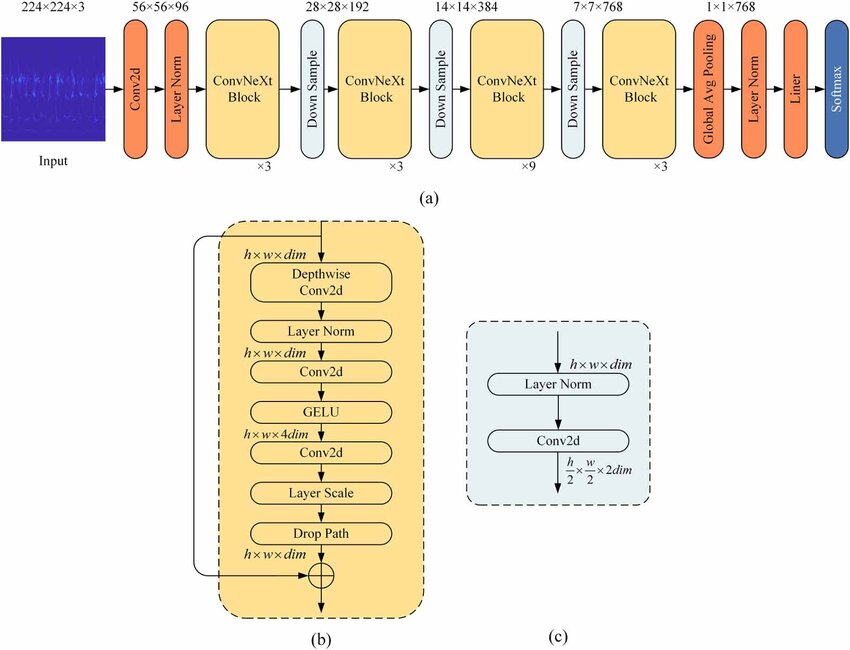

In [ ]:
class BBBLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last", priors=None):
        """
        Bayesian LayerNorm with reparameterized sampling for weight and bias.

        Args:
            normalized_shape: Shape for normalization.
            eps: Small value for numerical stability.
            data_format: Either "channels_last" or "channels_first".
            priors: Dictionary specifying prior distributions for mu and rho.
        """
        super().__init__()
        self.normalized_shape = (normalized_shape,)
        self.eps = eps
        self.data_format = data_format
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError

        if priors is None:
            priors = {
                'prior_mu': 0,
                'prior_sigma': 0.1,
                'posterior_mu_initial': (0, 0.1),
                'posterior_rho_initial': (-3, 0.1),
            }
        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        # Weight and bias parameters with Bayesian initialization
        self.weight_mu = nn.Parameter(torch.empty(normalized_shape, device=self.device))
        self.weight_rho = nn.Parameter(torch.empty(normalized_shape, device=self.device))
        self.bias_mu = nn.Parameter(torch.empty(normalized_shape, device=self.device))
        self.bias_rho = nn.Parameter(torch.empty(normalized_shape, device=self.device))

        self.reset_parameters()

    def reset_parameters(self):
        self.weight_mu.data.normal_(*self.posterior_mu_initial)
        self.weight_rho.data.normal_(*self.posterior_rho_initial)
        self.bias_mu.data.normal_(*self.posterior_mu_initial)
        self.bias_rho.data.normal_(*self.posterior_rho_initial)

    def kl_loss(self):
        kl_weight = calculate_kl(self.prior_mu, self.prior_sigma, self.weight_mu, self._sigma(self.weight_rho))
        kl_bias = calculate_kl(self.prior_mu, self.prior_sigma, self.bias_mu, self._sigma(self.bias_rho))
        return kl_weight + kl_bias

    def _sigma(self, rho):
        return torch.log1p(torch.exp(rho))

    def forward(self, x, sample=True):
        if self.training or sample:
            weight_eps = torch.empty(self.weight_mu.size()).normal_(0, 1).to(self.device)
            bias_eps = torch.empty(self.bias_mu.size()).normal_(0, 1).to(self.device)

            weight_sigma = self._sigma(self.weight_rho)
            bias_sigma = self._sigma(self.bias_rho)

            weight = self.weight_mu + weight_eps * weight_sigma
            bias = self.bias_mu + bias_eps * bias_sigma
        else:
            weight = self.weight_mu
            bias = self.bias_mu

        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, weight, bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = weight[:, None, None] * x + bias[:, None, None]
            return x

class Permute(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.dims = dims

    def forward(self, x):
        return torch.permute(x, self.dims)


class ConvNextBlock(nn.Module):
    """
      A block used in ConvNeXT architecture with Bayesian layers, incorporating convolution, normalization,
      and linear transformations with GELU activation.

      Arguments:
          filter_dim (int): The number of input and output channels for the block.
          layer_scale (float, optional): A scaling factor applied to the output of the block (default is 1e-6).

      Attributes:
          block (nn.Sequential): A sequence of operations including a convolution, layer normalization, linear transformations, and GELU activation.
          gamma (nn.Parameter): A learnable parameter used for scaling the output of the block.

      Methods:
          forward(x): Passes input `x` through the block and applies the scaling factor `gamma`.
    """
    def __init__(self, filter_dim, layer_scale=1e-6):
        super().__init__()

        self.block = nn.Sequential(*[
            BBBConv2d(filter_dim, filter_dim, kernel_size=7, padding=3, groups=filter_dim),
            Permute([0, 2, 3, 1]),
            BBBLayerNorm(filter_dim, eps=1e-6),
            BBBLinear(filter_dim, filter_dim * 4),
            nn.GELU(),
            BBBLinear(filter_dim * 4, filter_dim),
            Permute([0, 3, 1, 2])
        ])
        self.gamma = nn.Parameter(torch.ones(filter_dim, 1, 1) * layer_scale)

    def forward(self, x):
        return self.block(x) * self.gamma


class ConvNextLayer(nn.Module):
    """
      A layer of ConvNeXT blocks stacked together, with stochastic depth applied during training. It has a layer with multiple
      ConvNeXT blocks and applies stochastic depth during training to improve generalization.

      Arguments:
          filter_dim (int): The number of input and output channels for each block.
          depth (int): The number of ConvNeXT blocks in this layer.
          drop_rates (list of floats): A list of drop rates for stochastic depth for each block.

      Attributes:
          blocks (nn.ModuleList): A list of ConvNeXT blocks.
          drop_rates (list of floats): Drop rates for stochastic depth.

      Methods:
          forward(x): Passes input `x` through each ConvNeXT block with stochastic depth applied.
    """
    def __init__(self, filter_dim, depth, drop_rates):
        super().__init__()
        self.blocks = nn.ModuleList([])

        for _ in range(depth):
            self.blocks.append(ConvNextBlock(filter_dim=filter_dim))

        self.drop_rates = drop_rates

    def forward(self, x):
        for idx, block in enumerate(self.blocks):
            x = x + stochastic_depth(block(x),
                                     self.drop_rates[idx],
                                     mode="batch",
                                     training=self.training)
        return x

class ConvNext(ModuleWrapper):
    def __init__(self,
                 num_channels=3,
                 num_classes=10,
                 patch_size=4,
                 layer_dims=[96, 192, 384, 768],
                 depths=[3, 3, 9, 3],
                 drop_rate=0.):
        super().__init__()
        """
            A ConvNeXT architecture built with custom Bayesian Layers -> BBBConv2d, BBBLayerNorm, BBBLinear.
            The network consists of convolutional blocks, followed by ConvNeXT blocks and downsampling layers.
            After feature extraction, the model applies global average pooling, followed by layer normalization.
            The output is then passed through a Bayesian linear layer, and finally, the results are obtained
            through a softmax function for classification.

            Args:
                num_channels (int, optional): The number of input channels (default is 3).
                num_classes (int, optional): The number of output classes for classification (default is 10).
                patch_size (int, optional): The patch size used for the initial convolution (default is 4).
                layer_dims (list of int, optional): The dimensions of the layers at each stage (default is [96, 192, 384, 768]).
                depths (list of int, optional): The number of ConvNeXT blocks at each stage (default is [3, 3, 9, 3]).
                drop_rate (float, optional): The maximum drop rate for stochastic depth (default is 0.0).
        """
        # init downsample layers with stem
        self.num_classes = num_classes
        self.downsample_layers = nn.ModuleList(
            [nn.Sequential(
                BBBConv2d(in_channels = num_channels, out_channels= layer_dims[0], kernel_size=patch_size, stride=patch_size),
                BBBLayerNorm(layer_dims[0], eps=1e-6, data_format="channels_first")
            )])
        for idx in range(len(layer_dims) - 1):
            self.downsample_layers.append(
                nn.Sequential(
                    BBBLayerNorm(layer_dims[idx], eps=1e-6, data_format="channels_first"),
                    BBBConv2d(layer_dims[idx], layer_dims[idx + 1], kernel_size=2, stride=2),
                ))

        drop_rates = [x.item() for x in torch.linspace(0, drop_rate, sum(depths))]
        self.stage_layers = nn.ModuleList([])
        for idx, layer_dim in enumerate(layer_dims):
            layer_dr = drop_rates[sum(depths[:idx]): sum(depths[:idx]) + depths[idx]]
            self.stage_layers.append(
                ConvNextLayer(filter_dim=layer_dim, depth=depths[idx], drop_rates=layer_dr))

        self.cls = nn.Sequential(
            BBBLayerNorm(layer_dims[-1], eps=1e-6),
            BBBLinear(layer_dims[-1], num_classes)
        )

    def forward(self, x):
        all_layers = list(zip(self.downsample_layers, self.stage_layers))
        for downsample_layer, stage_layer in all_layers:
            x = downsample_layer(x)
            x = stage_layer(x)

        x = self.cls(x.mean(dim=(-2, -1)))
        kl_div = 0.0
        for module in self.modules():
            if hasattr(module, 'kl_loss'):
                kl_div += module.kl_loss()
        return x, kl_div

In [ ]:
def train_model(net, optimizer, criterion, trainloader, num_ens=1, beta=0.1, epoch=None, num_epochs=None):
    net.train()
    training_loss = 0.0
    accs = []
    kl_list = []
    for i, (inputs, labels) in enumerate(trainloader, 1):

        optimizer.zero_grad()

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)

        kl = 0.0
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1)

        kl = kl / num_ens
        kl_list.append(kl.item())
        log_outputs = logmeanexp(outputs, dim=2)

        loss = criterion(log_outputs, labels, kl, beta)
        loss.backward()
        optimizer.step()

        accs.append(acc(log_outputs.data, labels))
        training_loss += loss.cpu().data.numpy()
    return training_loss/len(trainloader), np.mean(accs), np.mean(kl_list)


def validate_model(net, criterion, validloader, num_ens=1, beta=0.1, epoch=None, num_epochs=None):
    """Calculate ensemble accuracy and NLL Loss"""
    net.train()
    valid_loss = 0.0
    accs = []


    for i, (inputs, labels) in enumerate(validloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)
        kl = 0.0
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1).data

        log_outputs = logmeanexp(outputs, dim=2)

        valid_loss += criterion(log_outputs, labels, kl, beta).item()
        accs.append(acc(log_outputs, labels))

    return valid_loss/len(validloader), np.mean(accs)

def test_model(net, criterion, test_loader, num_ens=1, epoch=None, num_epochs=None):
    """Calculate test accuracy and NLL Loss"""
    net.eval()  # Set model to evaluation mode
    test_loss = 0.0
    accs = []

    with torch.no_grad():  # No need to compute gradients during testing
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)
            for j in range(num_ens):
                net_out, _kl = net(inputs)  # Ignore the KL term for testing if not used
                outputs[:, :, j] = F.log_softmax(net_out, dim=1).data

            log_outputs = logmeanexp(outputs, dim=2)

            # Calculate the test loss and accuracy
            test_loss += criterion(log_outputs, labels, 0, 0).item()  # No KL term
            accs.append(acc(log_outputs, labels))

    return test_loss / len(test_loader), np.mean(accs)


def plot_metrics(train_losses, train_accuracies, train_kl_divs, valid_losses, valid_accuracies, n_epochs):
    """The function plot_metrics visualizes the training process by plotting key metrics over the epochs.
       It creates three plots:
            1. The progression of Training and Validation Loss over the epochs.
            2. The change in Training and Validation Accuracy across epochs.
            3. The trend of Training KL Divergence over the training epochs.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(n_epochs), train_losses, label='Training Loss')
    plt.plot(range(n_epochs), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(n_epochs), train_accuracies, label='Training Accuracy')
    plt.plot(range(n_epochs), valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(n_epochs), train_kl_divs, label='Training KL Divergence', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('KL Divergence')
    plt.title('Training KL Divergence')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def getModel(net_type, inputs, outputs, priors, layer_type, activation_type):
    if net_type == 'lenet':
        return BBBLeNet(outputs, inputs, priors, layer_type, activation_type)
    elif net_type == 'alexnet':
        return BBBAlexNet(outputs, inputs, priors, layer_type, activation_type)
    elif net_type == 'resnet':
        return BBBResNet50(outputs, inputs, priors, layer_type, activation_type)
    elif net_type == 'convnext':
            return  ConvNext(num_channels = inputs, num_classes=outputs)
    else:
        raise ValueError(f"Unknown model type: {net_type}")

def run(dataset, net_type):

    # Hyper Parameter settings
    layer_type = 'bbb'
    activation_type = 'softplus'  # 'softplus' or 'relu
    priors={
        'prior_mu': 0,
        'prior_sigma': 0.1,
        'posterior_mu_initial': (0, 0.1),  # (mean, std) normal_
        'posterior_rho_initial': (-5, 0.1),  # (mean, std) normal_
    }

    n_epochs = 150
    lr_start = 0.001
    num_workers = 4
    valid_size = 0.2
    batch_size = 256
    train_ens = 1
    valid_ens = 1
    beta = 0.1

    trainset, testset, inputs, outputs = getDataset(dataset)

    train_loader, valid_loader, test_loader = getDataloader(
        trainset, testset, valid_size, batch_size, num_workers)
    net = getModel(net_type, inputs, outputs, priors, 'bbb', activation_type).to(device)

    ckpt_dir = f'checkpoints/{dataset}/bayesian'
    ckpt_name = f'checkpoints/{dataset}/bayesian/model_{net_type}_{layer_type}_{activation_type}.pt'

    if not os.path.exists(ckpt_dir):
        print("MODEL ALREADY EXIST")
        os.makedirs(ckpt_dir, exist_ok=True)

    criterion = ELBO(len(trainset)).to(device)
    optimizer = Adam(net.parameters(), lr=lr_start)
    lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
    valid_loss_max = np.Inf
    train_losses, train_accuracies, train_kl_divs = [], [], []
    valid_losses, valid_accuracies = [], []
    for epoch in range(n_epochs):

        train_loss, train_acc, train_kl = train_model(net, optimizer, criterion, train_loader, num_ens=train_ens, beta=beta, epoch=epoch, num_epochs=n_epochs)
        valid_loss, valid_acc = validate_model(net, criterion, valid_loader, num_ens=valid_ens, beta=beta, epoch=epoch, num_epochs=n_epochs)
        lr_sched.step(valid_loss)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_kl_divs.append(train_kl)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f} \ttrain_kl_div: {:.4f}'.format(
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))

        if valid_loss <= valid_loss_max:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_max, valid_loss))
            torch.save(net.state_dict(), ckpt_name)
            valid_loss_max = valid_loss

    test_loss, test_accuracy = test_model(net, criterion, test_loader, num_ens=1)
    plot_metrics(train_losses, train_accuracies, train_kl_divs, valid_losses, valid_accuracies, n_epochs)
    print('Test Loss: {:.4f} \tTest Accuracy: {:.4f}'.format(
           test_loss, test_accuracy))
    return net

Files already downloaded and verified
Files already downloaded and verified
Epoch: 0 	Training Loss: 998302.2631 	Training Accuracy: 0.1067 	Validation Loss: 715018.3344 	Validation Accuracy: 0.1358 	train_kl_div: 8820399.5064
Validation loss decreased (inf --> 715018.334375).  Saving model ...
Epoch: 1 	Training Loss: 611142.7898 	Training Accuracy: 0.1997 	Validation Loss: 535736.3906 	Validation Accuracy: 0.2323 	train_kl_div: 5037890.9586
Validation loss decreased (715018.334375 --> 535736.390625).  Saving model ...
Epoch: 2 	Training Loss: 488633.0096 	Training Accuracy: 0.2379 	Validation Loss: 447031.4008 	Validation Accuracy: 0.2448 	train_kl_div: 3855921.9188
Validation loss decreased (535736.390625 --> 447031.400781).  Saving model ...
Epoch: 3 	Training Loss: 415424.1483 	Training Accuracy: 0.2485 	Validation Loss: 387050.4914 	Validation Accuracy: 0.2319 	train_kl_div: 3134884.3710
Validation loss decreased (447031.400781 --> 387050.491406).  Saving model ...
Epoch: 4 	Trai

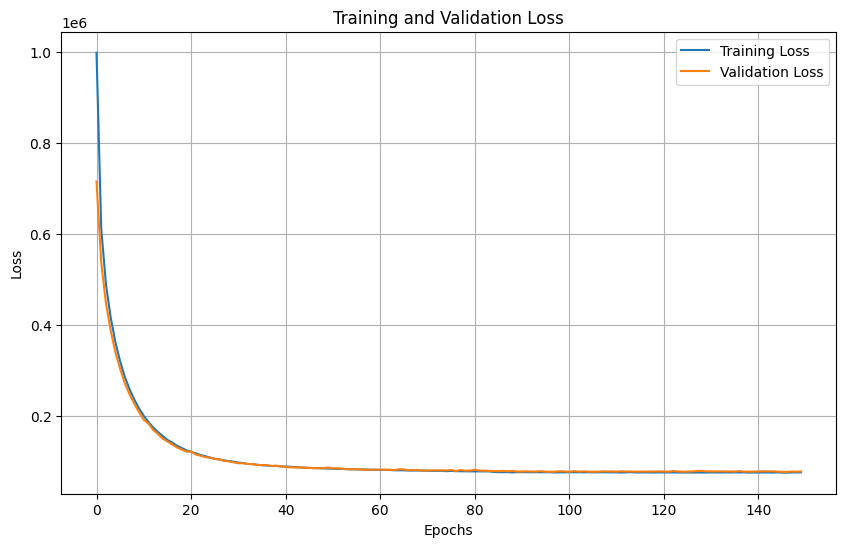

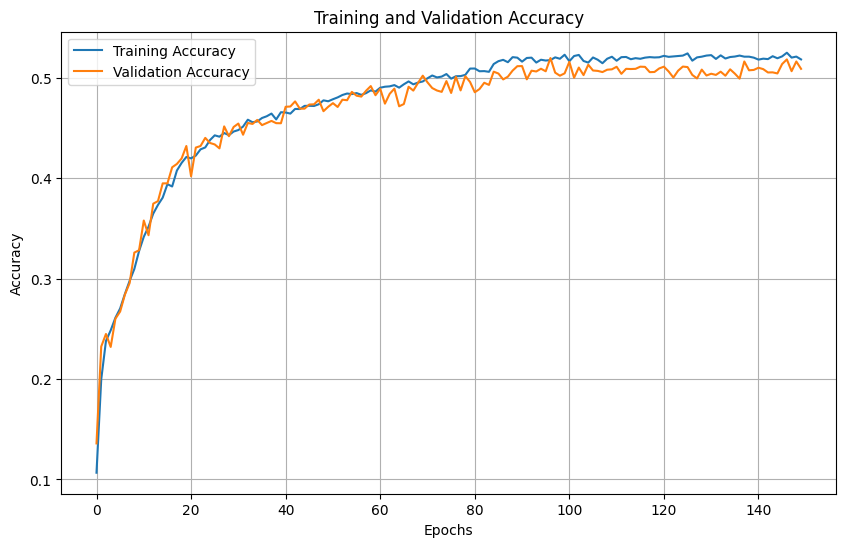

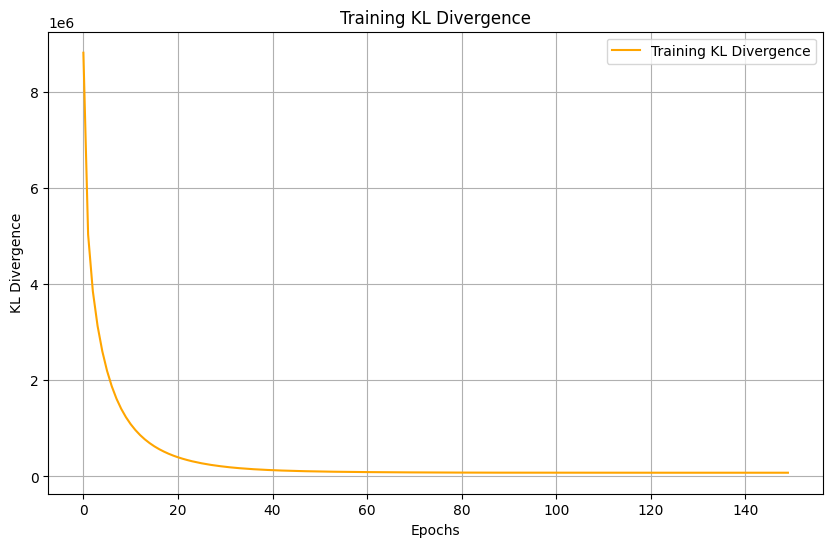

Test Loss: 68591.6501 	Test Accuracy: 0.5113


In [ ]:
if __name__ == '__main__':
    net_type='lenet'
    dataset = 'CIFAR10'
    model = run(dataset,net_type)

In [ ]:
# Hyper Parameter settings
layer_type = 'bbb'
activation_type = 'softplus'  # 'softplus' or 'relu
priors={
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0, 0.1),  # (mean, std) normal_
    'posterior_rho_initial': (-5, 0.1),  # (mean, std) normal_
}
net_type='lenet'
dataset = 'CIFAR10'
n_epochs = 10
lr_start = 0.001
num_workers = 4
valid_size = 0.2
batch_size = 256
train_ens = 1
valid_ens = 1
beta_type = 0.1

trainset, testset, inputs, outputs = getDataset('CIFAR10')

train_loader, valid_loader, test_loader = getDataloader(
    trainset, testset, valid_size, batch_size, num_workers)
net = getModel('lenet', inputs, outputs, priors, 'bbb', activation_type).to(device)

ckpt_dir = f'checkpoints/{dataset}/bayesian'
ckpt_name = f'checkpoints/{dataset}/bayesian/model_{net_type}_{layer_type}_{activation_type}.pt'

if not os.path.exists(ckpt_dir):
    print("MODEL ALREADY EXIST")
    os.makedirs(ckpt_dir, exist_ok=True)

criterion = ELBO(len(trainset)).to(device)
optimizer = Adam(net.parameters(), lr=lr_start)
lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
valid_loss_max = np.Inf
for epoch in range(n_epochs):  # loop over the dataset multiple times

    train_loss, train_acc, train_kl = train_model(net, optimizer, criterion, train_loader, num_ens=train_ens, beta_type=beta_type, epoch=epoch, num_epochs=n_epochs)
    valid_loss, valid_acc = validate_model(net, criterion, valid_loader, num_ens=valid_ens, beta_type=beta_type, epoch=epoch, num_epochs=n_epochs)
    lr_sched.step(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f} \ttrain_kl_div: {:.4f}'.format(
        epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))

    # save model if validation accuracy has increased
    if valid_loss <= valid_loss_max:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_max, valid_loss))
        torch.save(net.state_dict(), ckpt_name)
        valid_loss_max = valid_loss